In [3]:
import numpy as np
import tensorflow as tf
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
X_train = np.load('./data/X_train.npy')
Y_train = np.load('./data/Y_train.npy')
X_validation = np.load('./data/X_val.npy')
Y_validation = np.load('./data/Y_val.npy')
X_test = np.load('./data/X_test.npy')
Y_test = np.load('./data/Y_test.npy')

min:  -0.63853276 
max:  0.5564938 
mean:  -1.0648628e-05 
median:  2.0017981e-07 
variance:  0.005960775 
length:  15976


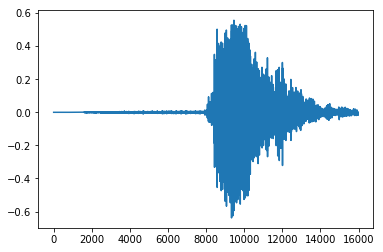

In [246]:
import matplotlib.pyplot as plt
# 기본적인 데이터에 대한 정리 
x, r = librosa.load(train_dir +'down3.wav', sr = 16000)
print('min: ',np.min(x), 
      '\nmax: ', np.max(x), 
      '\nmean: ', np.mean(x),
      '\nmedian: ', np.median(x),
      '\nvariance: ', np.var(x),
      '\nlength: ', len(x))
plt.plot(x)

In [5]:
n_values = np.max(Y_test) + 1
y_test_one_hot = np.eye(n_values)[Y_test]

In [6]:
y_test_one_hot.shape

(31841, 15)

In [7]:
n_values = np.max(Y_train) + 1
y_train_one_hot = np.eye(n_values)[Y_train]

In [8]:
y_train_one_hot.shape

(47857, 15)

In [9]:
n_values = np.max(Y_validation) + 1
y_validation_one_hot = np.eye(n_values)[Y_validation]

In [10]:
y_validation_one_hot.shape

(26533, 15)

## CNN

In [11]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense
from tensorflow.keras import optimizers, activations, models, losses

In [12]:
input_shape = (122, 85, 1)
nclass = 15
inp = Input(shape=input_shape)
norm_inp = BatchNormalization()(inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(norm_inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Flatten()(img_1)

dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

model = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

model.compile(optimizer=opt, loss=losses.binary_crossentropy)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 122, 85, 1)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 122, 85, 1)        4         
_________________________________________________________________
conv2d (Conv2D)              (None, 121, 84, 8)        40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 83, 8)        264       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 41, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 41, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 39, 16)        1168      
__________

In [13]:
model.fit(X_train, y_train_one_hot, batch_size=16, validation_data = (X_validation, y_validation_one_hot), epochs=3, shuffle=True, verbose=1)

Train on 47857 samples, validate on 26533 samples
Epoch 1/3
47857/47857 [==============================] - 321s 7ms/step - loss: 0.1032 - val_loss: 0.0736
Epoch 2/3
47857/47857 [==============================] - 300s 6ms/step - loss: 0.0628 - val_loss: 0.0501
Epoch 3/3
47857/47857 [==============================] - 308s 6ms/step - loss: 0.0518 - val_loss: 0.0433


In [14]:
result = model.predict(X_test, batch_size=16, verbose=1)

31841/31841 [==============================] - 45s 1ms/step


In [15]:
acc = 0 
for i in range(len(result)):
    if(result[i].argmax() == Y_test[i]):
        acc += 1
print(acc / 31841)

0.8914606953299206


## Save Models

In [19]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

NameError: name 'model' is not defined

In [22]:
import tensorflow as tf

In [23]:
from tensorflow.keras.models import load_model

In [24]:
model = load_model('my_model.h5')

In [25]:
result = model.predict(X_test, batch_size=16, verbose=1)

31841/31841 [==============================] - 46s 1ms/step


In [26]:
acc = 0 
for i in range(len(result)):
    if(result[i].argmax() == Y_test[i]):
        acc += 1
print(acc / 31841)

0.8914606953299206


In [2]:
def make_spec(file,flip = False, ps = False, st = 4):
    """
    create a melspectrogram from the amplitude of the sound
    
    Args:
        file (str): filename
        file_dir (str): directory path
        flip (bool): reverse time axis
        ps (bool): pitch shift
        st (int): half-note steps for pitch shift
    Returns:
        np.array with shape (122,85) (time, freq)
    """
    sig, rate = librosa.load(file, sr = 16000)
    if len(sig) < 16000: # pad shorter than 1 sec audio with ramp to zero
        sig = np.pad(sig, (0,16000-len(sig)), 'linear_ramp')
    if ps:
        # Pitch-shift the waveform by `n_steps` half-steps. 
        sig = librosa.effects.pitch_shift(sig, rate, st)
        
    # Convert an amplitude spectrogram to dB-scaled spectrogram.
    D = librosa.amplitude_to_db(librosa.stft(sig[:16000], n_fft = 512, 
                                             hop_length = 128, 
                                             center = False), ref = np.max)
    # Compute a mel-scaled spectrogram.
    S = librosa.feature.melspectrogram(S=D, n_mels = 85).T
    if flip:
        # Flip array in the up/down direction.
        S = np.flipud(S)
    return S.astype(np.float32)

In [ ]:
def predict(file):
    import librosa
    from tensorflow.keras.models import load_model
    model = load_model('my_model.h5')
    classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'backward', 'forward','house','silence', 'unknown']

    command = make_spec(file)
    command = np.expand_dims(command, -1)+1.3
    command = np.expand_dims(command, 0)
    result1 = model.predict(command, batch_size=16, verbose=1)
    
    return classes[result1.argmax()]

In [379]:
import librosa

command = make_spec('command.wav')
command = np.expand_dims(command, -1)+1.3
command = np.expand_dims(command, 0)
result1 = model.predict(command, batch_size=16, verbose=1)
classes[result1.argmax()]

1/1 [==============================] - 0s 4ms/step


/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:960: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


'silence'

In [376]:
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'backward', 'forward',
           'house',
           'silence', 'unknown']

## 15 clustering

In [380]:
Xtrain = np.load('data/Xtrain.npy')
ytrain = np.load('data/ytrain.npy')
Xtest = np.load('data/Xtest.npy')
ytest = np.load('data/ytest.npy')
Xval = np.load('data/Xval.npy')
yval = np.load('data/yval.npy')

In [382]:
n_values = np.max(ytrain) + 1
ytrainonehot = np.eye(n_values)[ytrain]
n_values = np.max(yval) + 1
yvalonehot = np.eye(n_values)[yval]
n_values = np.max(ytest) + 1
ytestonehot = np.eye(n_values)[ytest]

In [383]:
input_shape = (122, 85, 1)
nclass = 13
inp = Input(shape=input_shape)
norm_inp = BatchNormalization()(inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(norm_inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Flatten()(img_1)

dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

model2 = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

model2.compile(optimizer=opt, loss=losses.binary_crossentropy)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 122, 85, 1)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 122, 85, 1)        4         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 121, 84, 8)        40        
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 120, 83, 8)        264       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 60, 41, 8)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 41, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 58, 39, 16)        1168      
__________

In [387]:
model2.fit(Xtrain, ytrainonehot, batch_size=16, validation_data = (Xval, yvalonehot), epochs=3, shuffle=True, verbose=1)

Train on 13154 samples, validate on 10963 samples
Epoch 1/3
13154/13154 [==============================] - 104s 8ms/step - loss: 0.1726 - val_loss: 0.2278
Epoch 2/3
13154/13154 [==============================] - 98s 7ms/step - loss: 0.1034 - val_loss: 0.1297
Epoch 3/3
13154/13154 [==============================] - 105s 8ms/step - loss: 0.0823 - val_loss: 0.0814


In [388]:
result = model2.predict(Xtest, batch_size=16, verbose=1)

13154/13154 [==============================] - 23s 2ms/step


In [389]:
acc = 0 
for i in range(len(result)):
    if(result[i].argmax() == ytest[i]):
        acc += 1
print(acc / 31841)

0.3502716623221632
